## Agent-Based Model for MRT System

long vs short
vol const
seed const
cap const
bias towards 1. origin (0 priority) and 2. dest (1 priority)

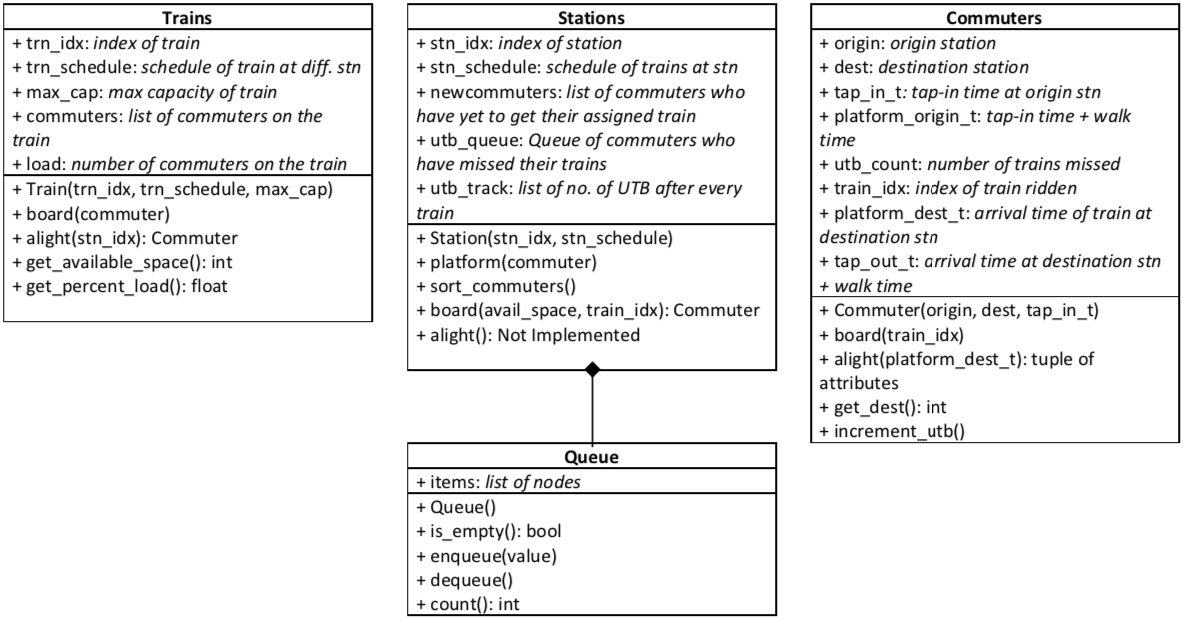

## Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

## Delay Function

In [2]:
def delay(mu, beta, size=0):
    return 0
    """
    Generate wait time using samples from a Gumbel distribution.
    """
    if size == 0:
        return np.random.gumbel(mu, beta)
    else:
        return np.random.gumbel(mu, beta, size)

## Agents

### Trains

In [3]:
class Train:
    def __init__(self, trn_idx, trn_schedule, max_capacity):
        self.trn_idx = trn_idx
        self.trn_schedule = trn_schedule
        self.max_capacity = max_capacity
        self.load = 0
        self.commuters = []
        self.load_track = [] #percentage values
        
    def board(self, commuter):
        self.commuters.append(commuter)
        self.load += 1
        
    def alight(self, station_no):
        for commuter in self.commuters[:]:
            if commuter.get_dest() == station_no:
                self.load -= 1
                self.commuters.remove(commuter)
                yield commuter
                
    def get_avail_space(self) -> int:
        return self.max_capacity - self.load
    
    def get_percent_load(self) -> float: #unused
        return self.load / self.max_capacity * 100
    
    def boarding_done(self):
        self.load_track.append(self.load)
        
    def dump(self):
        return self.load_track
                

### Stations

In [4]:
class Queue:
    def __init__(self):
        self.items = []
        
    def is_empty(self):
        return self.items == []
        
    def enqueue(self, value):
        self.items.append(value)
        
    def dequeue(self):
        if not self.is_empty():
            return self.items.pop(0)
        
    def count(self):
        return len(self.items)


In [5]:
#Composite relationship: Station has a queue
class Station:
    def __init__(self, stn_idx, stn_schedule):
        self.stn_idx = stn_idx
        self.stn_schedule = stn_schedule
        self.new_commuters = []
        self.utb_queue = Queue()
        self.utb_track = []
        
    def platform(self, commuter):
        self.new_commuters.append(commuter)
        
    def sort_commuters(self):
        self.new_commuters = sorted(self.new_commuters, key=lambda x: x.get_platform_o_t())
        
    def board(self, r_board, avail_space, trn_idx, time):
        arr = self.stn_schedule[trn_idx][0]
        dep = self.stn_schedule[trn_idx][1]
        max_commuters = min((dep - arr - time) * r_board, avail_space)
        
        while not self.utb_queue.is_empty() and max_commuters > 0:
            max_commuters -= 1
            commuter = self.utb_queue.dequeue()
            commuter.board(trn_idx)
            yield commuter
            
        if trn_idx == 0:
            prev_dep = -100000
        else:
            prev_dep = self.stn_schedule[trn_idx-1][1]
            
        while self.new_commuters != [] and prev_dep < self.new_commuters[0].get_platform_o_t() <= dep and max_commuters > 0:
            max_commuters -= 1
            commuter = self.new_commuters.pop(0)
            commuter.board(trn_idx)
            yield commuter
            
        utb = 0    
        if max_commuters == 0:
            while self.new_commuters != [] and prev_dep < self.new_commuters[0].get_platform_o_t() <= dep:
                utb += 1
                commuter = self.new_commuters.pop(0)
                self.utb_queue.enqueue(commuter)
                
        self.utb_track.append(utb)
            
    def alight(self, *args, **kwargs):
        """
        Alighting for Station is not relevant because
        1. The model only looks at station overcrowding from the unable to board due to 
        either (a): dwell time insufficient
        or (b): train is full
        
        It does not look at station overcrowding from a perspective of the load of the 
        station itself (i.e. too many people in the station causing people to be unable
        to tap in)
        """
        raise NotImplementedError

    def get_utb(self): #Unused
        return self.utb.count()
    
    def dump(self):
        return self.utb_track

### Commuters

In [6]:
class Commuter:
    #Wait time parameters
    MU = 30
    BETA = 10
    
    def __init__(self, origin, dest, tap_in_t):
        self.origin = origin
        self.dest = dest
        self.tap_in_t = tap_in_t
        self.platform_origin_t = self.tap_in_t + delay(Commuter.MU, Commuter.BETA)
        self.utb_count = 0
        self.trn_idx = None
        
        
    def board(self, trn_idx):
        self.trn_idx = trn_idx
        
    def alight(self, time):
        self.platform_dest_t = time
        self.tap_out_t = self.platform_dest_t + delay(Commuter.MU, Commuter.BETA)
        return (self.origin, self.dest, self.tap_in_t, self.platform_origin_t, \
                self.trn_idx, self.utb_count, self.platform_dest_t, self.tap_out_t)
        
    def get_dest(self) -> int:
        return self.dest
    
    def get_platform_o_t(self) -> float:
        return self.platform_origin_t
    
    def increment_utb(self):
        self.utb_count += 1
    

## Driver Code

### Functions

In [7]:
def generate_schedule(n_stn, cut_off, headway_time, dwell_time, edge_time):
    all_train_schedule = []
    n_train = 0
    
    #Generate first train
    train_schedule = []
    arr = 0
    dep = arr + dwell_time
    train_schedule.append((arr, dep))
    
    for stn in range(n_stn-1):
        arr = dep + edge_time[stn]
        dep = arr + dwell_time
        train_schedule.append((arr, dep))
        
    all_train_schedule.append(train_schedule)
    n_train += 1
        
    #Generate subsequent trains
    while train_schedule[1][0] < cut_off:
        train_schedule = []
        arr = all_train_schedule[n_train-1][0][0] + headway_time
        dep = arr + dwell_time
        train_schedule.append((arr, dep,))

        for stn in range(n_stn-1):
            arr = dep + edge_time[stn]
            dep = arr + dwell_time
            train_schedule.append((arr, dep,))
            
        all_train_schedule.append(train_schedule)
        n_train += 1
        
    return all_train_schedule
    
    

In [8]:
def get_a_train_schedule(index, schedule):
    return schedule[index]

### Parameters

In [31]:
N_STN = 10 #No. of stations
CUT_OFF = 0.5 * 60 * 60 #Cut-off time after which only one last train can arrive at the last station and no new passengers
FIRST_TRAIN = 7.5 * 60 * 60

#CONSTANT TIME CURRENTLY
travel_time = 2.5 * 60 #2.5 minutes (units: seconds)
dwell_time = 0.5 * 60
headway_time = 3 * 60

#travel time between links (constant for now)
edge_time = [travel_time for i in range(N_STN-1)]


In [32]:
schedule = generate_schedule(N_STN, CUT_OFF, headway_time, dwell_time, edge_time)
df_schedule = pd.DataFrame(schedule)
rolling_stock = [Train(i, "", 1000) for i in range(len(schedule))] #931
rolling_stock = np.array(rolling_stock)
stn_lst = [Station(i, df_schedule.loc[:, i]) for i in range(N_STN)]

In [33]:
df_schedule

,0,1,2,3,4,5,6,7,8,9
0,"(0, 30.0)","(180.0, 210.0)","(360.0, 390.0)","(540.0, 570.0)","(720.0, 750.0)","(900.0, 930.0)","(1080.0, 1110.0)","(1260.0, 1290.0)","(1440.0, 1470.0)","(1620.0, 1650.0)"
1,"(180, 210.0)","(360.0, 390.0)","(540.0, 570.0)","(720.0, 750.0)","(900.0, 930.0)","(1080.0, 1110.0)","(1260.0, 1290.0)","(1440.0, 1470.0)","(1620.0, 1650.0)","(1800.0, 1830.0)"
2,"(360, 390.0)","(540.0, 570.0)","(720.0, 750.0)","(900.0, 930.0)","(1080.0, 1110.0)","(1260.0, 1290.0)","(1440.0, 1470.0)","(1620.0, 1650.0)","(1800.0, 1830.0)","(1980.0, 2010.0)"
3,"(540, 570.0)","(720.0, 750.0)","(900.0, 930.0)","(1080.0, 1110.0)","(1260.0, 1290.0)","(1440.0, 1470.0)","(1620.0, 1650.0)","(1800.0, 1830.0)","(1980.0, 2010.0)","(2160.0, 2190.0)"
4,"(720, 750.0)","(900.0, 930.0)","(1080.0, 1110.0)","(1260.0, 1290.0)","(1440.0, 1470.0)","(1620.0, 1650.0)","(1800.0, 1830.0)","(1980.0, 2010.0)","(2160.0, 2190.0)","(2340.0, 2370.0)"
5,"(900, 930.0)","(1080.0, 1110.0)","(1260.0, 1290.0)","(1440.0, 1470.0)","(1620.0, 1650.0)","(1800.0, 1830.0)","(1980.0, 2010.0)","(2160.0, 2190.0)","(2340.0, 2370.0)","(2520.0, 2550.0)"
6,"(1080, 1110.0)","(1260.0, 1290.0)","(1440.0, 1470.0)","(1620.0, 1650.0)","(1800.0, 1830.0)","(1980.0, 2010.0)","(2160.0, 2190.0)","(2340.0, 2370.0)","(2520.0, 2550.0)","(2700.0, 2730.0)"
7,"(1260, 1290.0)","(1440.0, 1470.0)","(1620.0, 1650.0)","(1800.0, 1830.0)","(1980.0, 2010.0)","(2160.0, 2190.0)","(2340.0, 2370.0)","(2520.0, 2550.0)","(2700.0, 2730.0)","(2880.0, 2910.0)"
8,"(1440, 1470.0)","(1620.0, 1650.0)","(1800.0, 1830.0)","(1980.0, 2010.0)","(2160.0, 2190.0)","(2340.0, 2370.0)","(2520.0, 2550.0)","(2700.0, 2730.0)","(2880.0, 2910.0)","(3060.0, 3090.0)"
9,"(1620, 1650.0)","(1800.0, 1830.0)","(1980.0, 2010.0)","(2160.0, 2190.0)","(2340.0, 2370.0)","(2520.0, 2550.0)","(2700.0, 2730.0)","(2880.0, 2910.0)","(3060.0, 3090.0)","(3240.0, 3270.0)"


In [34]:
def generate_commuters(r_arr, cut_off, n_stn, f_schedule, l_schedule, adv_time):
    n_commuters = int(r_arr * cut_off)
    
    demand_matrix = np.zeros((n_stn, n_stn), dtype=np.int64) #(origin, dest)
    for i in range(n_stn):
        for j in range(n_stn):
            if j > i: #strictly upper triangular matrix
                demand_matrix[i,j] = n_commuters
                
    for origin, lst_common_origin in enumerate(demand_matrix):
        for dest, demand in enumerate(lst_common_origin):
            for i in range(demand):
                tap_in_t = np.random.uniform(f_schedule[origin][0] - adv_time, l_schedule[origin][0] - 0.5 * 60)
                commuter = Commuter(origin, dest, tap_in_t)
                stn_lst[origin].platform(commuter)
                
    for i in range(n_stn):
        stn_lst[i].sort_commuters()
                

In [35]:
def generate_commuters_nonrandom(r_arr, cut_off, n_stn, f_schedule, l_schedule, adv_time): #not random
    n_commuters = int(r_arr * cut_off)
    
    demand_matrix = np.zeros((n_stn, n_stn), dtype=np.int64) #(origin, dest)
    for i in range(n_stn):
        for j in range(n_stn):
            if j > i: #strictly upper triangular matrix
                demand_matrix[i,j] = n_commuters
               
    for origin, lst_common_origin in enumerate(demand_matrix):
        for dest, demand in enumerate(lst_common_origin):
            if dest > origin:
                for i in range(demand):
                    tap_in_t = f_schedule[origin][1] - adv_time + (1/r_arr) * (i+1)
                    if origin == 0 and 30 < tap_in_t <= 210:
                        tap_in_t += 180
                    commuter = Commuter(origin, dest, tap_in_t)
                    stn_lst[origin].platform(commuter)

    for i in range(n_stn):
        stn_lst[i].sort_commuters()
                

In [36]:
def generate_commuters_short(r_arr, cut_off, n_stn, f_schedule, l_schedule, adv_time): #not random
    n_commuters = int(r_arr * cut_off)
    
    demand_matrix = np.zeros((n_stn, n_stn), dtype=np.int64) #(origin, dest)
    for i in range(n_stn):
        for j in range(n_stn):
            if j == i+2: #strictly upper triangular matrix
                demand_matrix[i,j] = n_commuters
                
    print(demand_matrix)
                
    for origin, lst_common_origin in enumerate(demand_matrix):
        for dest, demand in enumerate(lst_common_origin):
            if dest > origin:
                for i in range(demand):
                    tap_in_t = f_schedule[origin][1] - adv_time + (1/r_arr) * (i+1)
                    if origin == 0 and 30 < tap_in_t <= 210: pass
                        #tap_in_t += 180
                    commuter = Commuter(origin, dest, tap_in_t)
                    stn_lst[origin].platform(commuter)

    for i in range(n_stn):
        stn_lst[i].sort_commuters()
                

In [37]:
def generate_commuters_long(r_arr, cut_off, n_stn, f_schedule, l_schedule, adv_time): #not random
    n_commuters = int(r_arr * cut_off)
    
    demand_matrix = np.zeros((n_stn, n_stn), dtype=np.int64) #(origin, dest)
    for i in range(n_stn):
        if i == 0:
            demand_matrix[i,n_stn-1] = n_commuters * 6
        else:
            demand_matrix[i,n_stn-1] = n_commuters
    
    print(demand_matrix)
    
    t2 = 0
    t3 = 0
    
    for origin, lst_common_origin in enumerate(demand_matrix):
        for dest, demand in enumerate(lst_common_origin):
            if dest > origin:
                for i in range(demand):
                    if origin != 0:
                        tap_in_t = f_schedule[origin][1] - adv_time + (1/r_arr) * (i+1)
                    else:
                        tap_in_t = f_schedule[origin][1] - adv_time + (0.1666666667/r_arr) * (i+1)
                    if origin == 0 and 30 < tap_in_t <= 210:
                        tap_in_t += 180
                    commuter = Commuter(origin, dest, tap_in_t)
                    stn_lst[origin].platform(commuter)
    for i in range(n_stn):
        stn_lst[i].sort_commuters()
                

In [38]:
f_schedule = get_a_train_schedule(0, schedule)
l_schedule = get_a_train_schedule(-1, schedule)
#generate_commuters(0.1, CUT_OFF, N_STN, f_schedule, l_schedule, 2.5*60)
#generate_commuters_nonrandom(0.1, CUT_OFF, N_STN, f_schedule, l_schedule, 3*60)
generate_commuters_short(1, CUT_OFF, N_STN, f_schedule, l_schedule, 3*60)
#generate_commuters_long(1, CUT_OFF, N_STN, f_schedule, l_schedule, 3*60)

[[   0    0 1800    0    0    0    0    0    0    0]
 [   0    0    0 1800    0    0    0    0    0    0]
 [   0    0    0    0 1800    0    0    0    0    0]
 [   0    0    0    0    0 1800    0    0    0    0]
 [   0    0    0    0    0    0 1800    0    0    0]
 [   0    0    0    0    0    0    0 1800    0    0]
 [   0    0    0    0    0    0    0    0 1800    0]
 [   0    0    0    0    0    0    0    0    0 1800]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


In [39]:
def run_simulation(r_alight, r_board, trn_lst, stn_lst, schedule):
    
    master_out = defaultdict(list)
    
    for stn_idx in range(len(stn_lst)):
        for trn_idx in range(len(trn_lst)):
            arr = schedule[trn_idx][stn_idx][0]
            dep = schedule[trn_idx][stn_idx][1]
            
            #perform alighting
            total_alight = 0
            for commuter in trn_lst[trn_idx].alight(stn_idx):
                output = commuter.alight(arr + total_alight / r_alight)
                
                master_out["Origin"].append(output[0])
                master_out["Destination"].append(output[1])
                master_out["TapInTime"].append(output[2])
                master_out["PlatformOriginTime"].append(output[3])
                master_out["TrainIdx"].append(output[4])
                master_out["UTB_Count"].append(output[5])
                master_out["PlatformDestTime"].append(output[6])
                master_out["TapOutTime"].append(output[7])
                
                del commuter #Conserve memory
                
                total_alight += 1
            
            #perform boarding
            avail_space = trn_lst[trn_idx].get_avail_space()
            time = total_alight / r_alight
            for commuter in stn_lst[stn_idx].board(r_board, avail_space, trn_idx, time):
                trn_lst[trn_idx].board(commuter)
            
            trn_lst[trn_idx].boarding_done()
    
    return master_out

In [40]:
k=0
for i in stn_lst:
    for j in i.new_commuters:
        k+=1
        
k

14400

In [41]:
out = run_simulation(10000, 10000, rolling_stock, stn_lst, schedule)
df = pd.DataFrame.from_dict(out)
#df.to_csv("oof.csv", header=True)
df

,Origin,Destination,TapInTime,PlatformOriginTime,TrainIdx,UTB_Count,PlatformDestTime,TapOutTime
0,0,2,-149.0,-149.0,0,0,360.0000,360.0000
1,0,2,-148.0,-148.0,0,0,360.0001,360.0001
2,0,2,-147.0,-147.0,0,0,360.0002,360.0002
3,0,2,-146.0,-146.0,0,0,360.0003,360.0003
4,0,2,-145.0,-145.0,0,0,360.0004,360.0004
...,...,...,...,...,...,...,...,...
14395,7,9,2906.0,2906.0,9,0,3240.0175,3240.0175
14396,7,9,2907.0,2907.0,9,0,3240.0176,3240.0176
14397,7,9,2908.0,2908.0,9,0,3240.0177,3240.0177
14398,7,9,2909.0,2909.0,9,0,3240.0178,3240.0178


In [42]:
k=0
for i in stn_lst:
    k += i.utb_queue.count()
        
k

0

In [43]:
def mem_dump(trn_lst, stn_lst):
    out1 = []
    for trn in trn_lst:
        out1.append(trn.dump())
        
    out1 = np.array(out1)
    df1 = pd.DataFrame(out1)
    
    out2 = []
    for stn in stn_lst:
        out2.append(stn.dump())
        
    out2 = np.array(out2)
    df2 = pd.DataFrame(out2).T
    return df1, df2
        
    

In [44]:
load_dump, utb_dump = mem_dump(rolling_stock, stn_lst)

In [45]:
load_stats = load_dump.loc[:, 4]
print(np.mean(load_stats))
print(np.var(load_stats))

360.0
0.0


In [46]:
#load_dump = load_dump.T
#utb_dump = utb_dump.T

In [47]:
#plot the dataframe
#fig,ax = plt.subplots(figsize=(100,80)) 

#ax.set_title('Train loading')
#array = load_dump.values
#plt.imshow(array, cmap='jet', interpolation='nearest')
#plt.colorbar(orientation='vertical')
#plt.show()

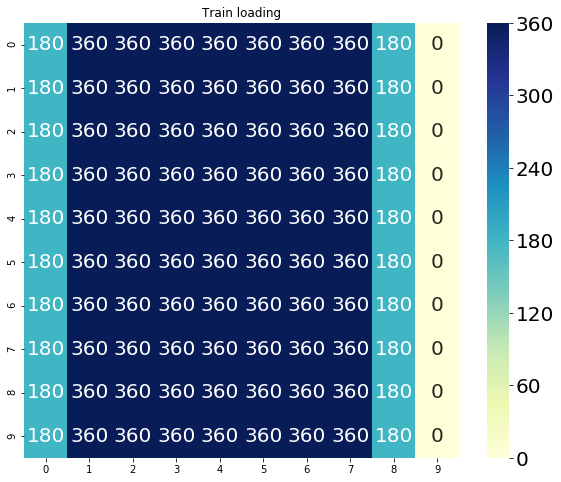

In [48]:
array = load_dump.values
fig,ax = plt.subplots(figsize=(10,8)) 
ax.set_title('Train loading')
plt.rcParams.update({'font.size': 20})
ax = sns.heatmap(array, cmap="YlGnBu", annot=True, fmt="d", square=True, cbar=True, cbar_kws={"shrink": 1})
#plt.savefig("test.svg")

In [49]:
load_dump

,0,1,2,3,4,5,6,7,8,9
0,180,360,360,360,360,360,360,360,180,0
1,180,360,360,360,360,360,360,360,180,0
2,180,360,360,360,360,360,360,360,180,0
3,180,360,360,360,360,360,360,360,180,0
4,180,360,360,360,360,360,360,360,180,0
5,180,360,360,360,360,360,360,360,180,0
6,180,360,360,360,360,360,360,360,180,0
7,180,360,360,360,360,360,360,360,180,0
8,180,360,360,360,360,360,360,360,180,0
9,180,360,360,360,360,360,360,360,180,0


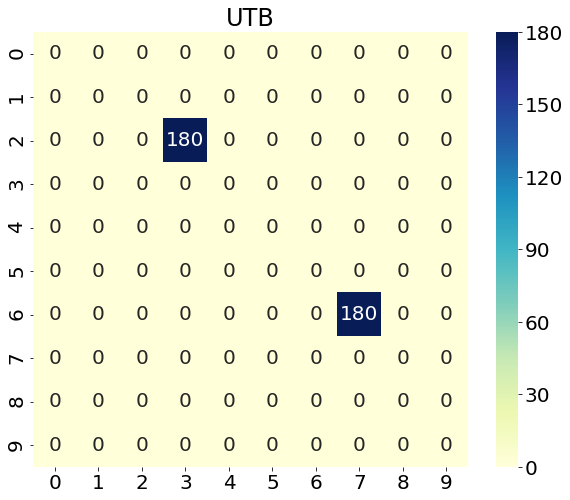

In [50]:
array = utb_dump.values
array[2][3] = 180
array[6][7] = 180
fig,ax = plt.subplots(figsize=(10,8)) 
ax.set_title('UTB')
plt.rcParams.update({'font.size': 20})
ax = sns.heatmap(array, cmap="YlGnBu", annot=True, fmt="d", square=True, cbar=True, cbar_kws={"shrink": 1})
plt.savefig("s1.png")

In [51]:
utb_dump

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,180,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,180,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0
